In [279]:
from datetime import datetime


# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams

rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# RNN 

In [253]:
import autograd.numpy as np 
import normalizers
import optimizer
import custom_plotter 
# import sequence plotter
import hidden_sequence_plotter as sequence_plotter

In [207]:
#### Simple RNN architecture class ####
class simple_RNN:
    def __init__(self,layers_dim,**kwargs):
        self.layers_dim = layers_dim
                
        
        # set default values for layer sizes, activation, and scale
        hidden_activation = 'tanh'
        out_activation = 'linear'

        # decide on these parameters via user input
        if 'activation' in kwargs:
            activation = kwargs['activation']
            hidden_activation = activation[0]
            out_activation = activation[1]
        
        # switches
        if hidden_activation == 'linear':
            self.hidden_activation = lambda data: data
        elif hidden_activation == 'tanh':
            self.hidden_activation = lambda data: np.tanh(data)
        elif hidden_activation == 'relu':
            self.hidden_activation = lambda data: np.maximum(0,data)
        elif hidden_activation == 'sinc':
            self.hidden_activation = lambda data: np.sinc(data)
        elif hidden_activation == 'sin':
            self.hidden_activation = lambda data: np.sin(data)
        elif hidden_activation == 'maxout':
            self.hidden_activation = lambda data1,data2: np.maximum(data1,data2)
            
        # switches
        if out_activation == 'linear':
            self.out_activation = lambda data: data
        elif out_activation == 'tanh':
            self.out_activation = lambda data: np.tanh(data)
        elif out_activation == 'relu':
            self.out_activation = lambda data: np.maximum(0,data)
        elif out_activation == 'sinc':
            self.out_activation = lambda data: np.sinc(data)
        elif out_activation == 'sin':
            self.out_activation = lambda data: np.sin(data)
        elif out_activation == 'maxout':
            self.out_activation = lambda data1,data2: np.maximum(data1,data2)
            
    def initializer(self,scale):
        
        layers_dim = self.layers_dim
        W_xh = np.random.randn(layers_dim[1],layers_dim[0]) * scale
        W_hh = np.random.randn(layers_dim[1],layers_dim[1]) * scale
        b_h = np.random.randn(layers_dim[1],1) * scale
        
        W_hidden = [W_xh,W_hh,b_h]
    
        W_hy = np.random.randn(layers_dim[2],layers_dim[1]) * scale
        b_y = np.random.randn(layers_dim[2],1) * scale
    
        W_out = [W_hy,b_y]
        
        W = [W_hidden,W_out]
        return W
        
    def update_equation(self,X_t,H_prev_t,W):
        H_t = self.hidden_activation(np.dot(W[0],X_t) + np.dot(W[1],H_prev_t) + W[2])
        return H_t
    
    def output_of_hiddenlayer(self,H_t,W):
        Y_t = self.out_activation(np.dot(W[0],H_t) + W[1])
        return Y_t
        
    def rnn(self,X_t,H_prev_t,W):
        H_t = self.update_equation(X_t,H_prev_t,W[0])
        Y_pre = self.output_of_hiddenlayer(H_t,W[1])
        
        return Y_pre,H_t

In [231]:
# input_sequence shape should be T*N, initial_state shape should be H*1
class RNN:
    def __init__(self,cell,input_sequence,output_sequence,hidden_dim,name,**kwargs):
        self.input_sequence = input_sequence
        self.output_sequence = output_sequence
        self.hidden_dim = hidden_dim
        
        self.scale=0.1
        if 'scale' in kwargs:
            self.scale = scale
        
        self.T = np.shape(input_sequence)[0]
        if name=='regression': 
            layers_dim = [np.shape(input_sequence)[1],self.hidden_dim,np.shape(output_sequence)[1]]
            
        if name=='classification':
            num_class = len(np.unique(output_sequence))
            layers_dim = [np.shape(input_sequence)[1],self.hidden_dim,num_class]
        
        #### choice for RNN architecture ####
        if cell=='simple_RNN':
            self.rnn_cell = simple_RNN(layers_dim,**kwargs)
            self.initializer = self.rnn_cell.initializer
        
    def initial_weights(self):
        return self.initializer(self.scale)
             
    def static_rnn(self,W):
        
        initial_state = np.zeros((self.hidden_dim,1))
        state = initial_state
        states = [initial_state]
        outputs = []
    
        for t in range(len(self.input_sequence)):
            current_input = self.input_sequence[t]
            current_input = np.reshape(current_input,(len(current_input),1))
            
            output,state = self.rnn_cell.rnn(current_input,state,W)
            
            outputs.append(output)
            states.append(state)
        
        outputs = np.array(outputs) 
        states = np.array(states) 
        
        outputs = np.reshape(outputs,(outputs.shape[0],outputs.shape[1]*outputs.shape[2]))
        return outputs,states
    
    def model(self,W):
        predict_sequence,states = self.static_rnn(W)
        return predict_sequence
    
    def least_squares(self,W):
        cost = np.sum((self.model(W)-self.output_sequence)**2)
        return cost/float(len(self.output_sequence))
    
    # multiclass softmax
    def multiclass_softmax(self,w):
        # pre-compute predictions on all points
        all_evals = self.model(w).T

        # compute softmax across data points
        a = np.log(np.sum(np.exp(all_evals),axis = 0)) 

        # compute cost in compact form using numpy broadcasting
        b = all_evals[self.output_sequence.astype(int).flatten(),np.arange(np.size(self.output_sequence))]
        cost = np.sum(a - b)

        # return average
        return cost/float(np.size(self.output_sequence))

    # multiclass misclassification cost function - aka the fusion rule
    def multiclass_counting_cost(self,w):                
        # pre-compute predictions on all points
        all_evals = self.model(w).T

        # compute predictions of each input point
        y_predict = (np.argmax(all_evals,axis = 0))[np.newaxis,:]

        # compare predicted label to actual label
        count = np.sum(np.abs(np.sign(self.output_sequence - y_predict)))

        # return number of misclassifications
        return count

# Implementing RNN on Time Sequence data

## 1.Making input/output pairs from the Time Sequence data

### 1.1 Load Dataset

In [32]:
### load in and normalize the dataset
dataset = np.loadtxt('dataset/normalized_apple_prices.csv')[:,np.newaxis]

In [33]:
print('original data structure:' + str(np.shape(dataset)))

original data structure:(138, 1)


#### Showing the sequence dataset

<IPython.core.display.Javascript object>


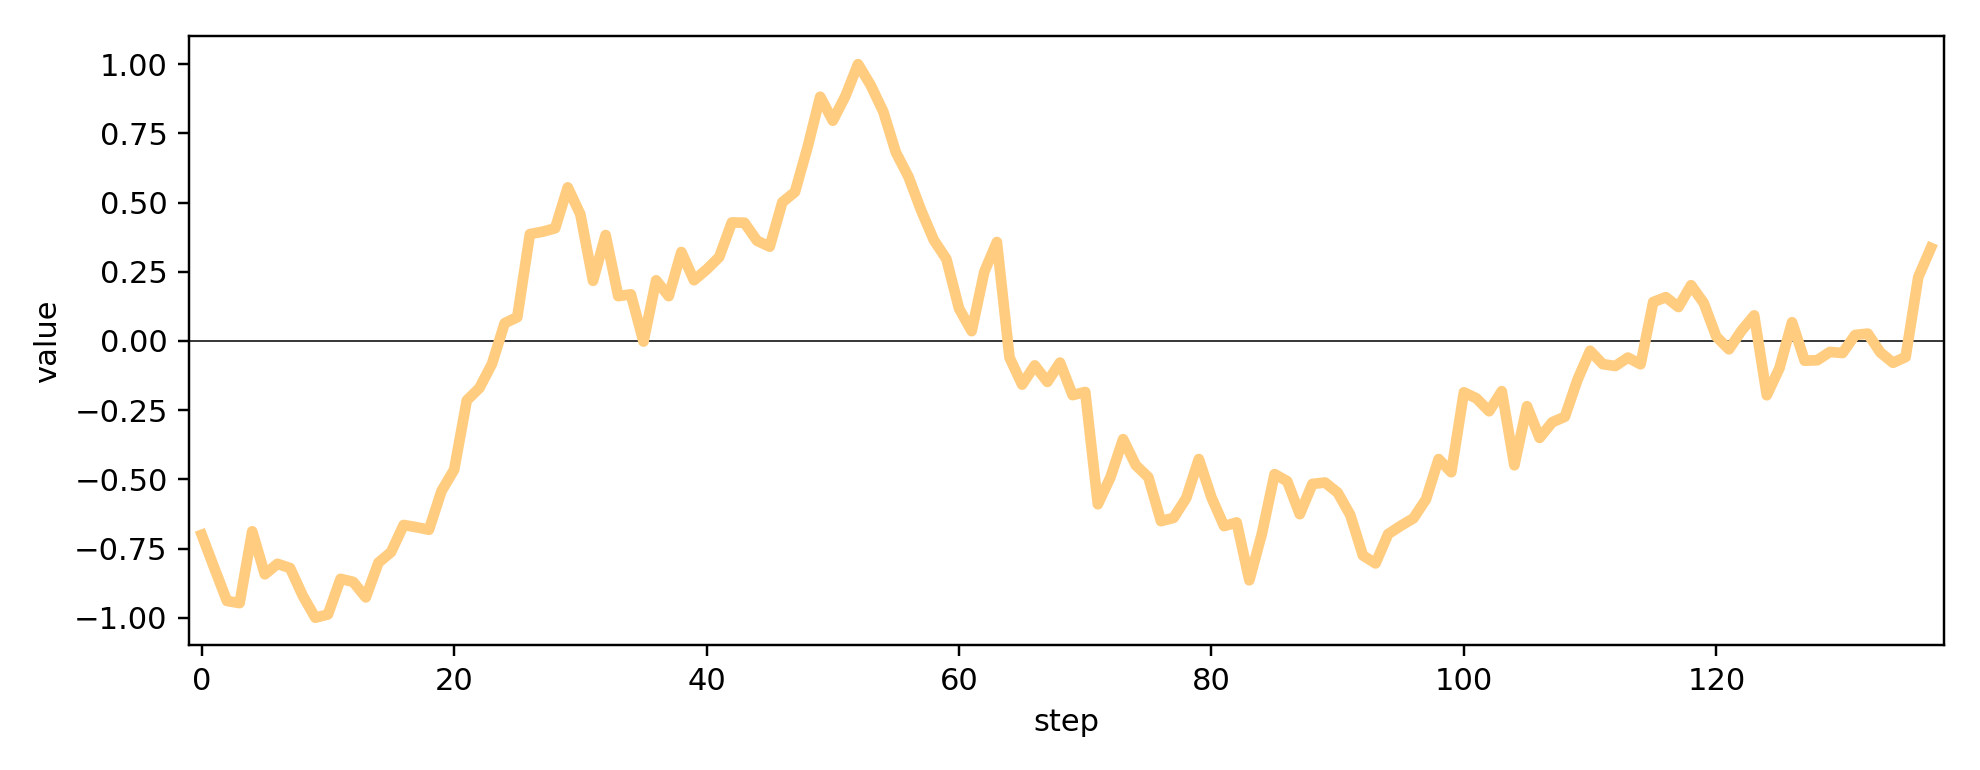

In [37]:
plot_demo = sequence_plotter.Visualizer()          
plot_demo.show_sequences(seq1 = dataset,seq2 = [])

### 1.2 Sliding function to generate input/output pairs

In [209]:
def window_transform_series(series,window_size):
    # containers for input/output pairs
    X = []
    y = []
    
    # window data
    count = 0
    for t in range(len(series) - window_size):
        # get input sequence
        temp_in = series[t:t + window_size]
        X.append(temp_in)
        
        # get corresponding target
        temp_target = series[t + window_size]
        y.append(temp_target)
        count+=1
        
    # reshape each 
    X = np.asarray(X)
    X.shape = (np.shape(X)[0:2])
    y = np.asarray(y)
    y.shape = (len(y),1)
    
    return X,y

In [210]:
# window the data using your windowing function
window_size = 7
X,Y = window_transform_series(series = dataset,window_size = window_size)

In [211]:
print('Input X structure:' + str(np.shape(X)))
print('Input Y structure:' + str(np.shape(Y)))

Input X structure:(131, 7)
Input Y structure:(131, 1)


#### Notice: The input_shape is (1,window_size) for each time step, cause this is one sequence, we can not seperate them as i.i.d.
**when the stride is S for the sliding operation, we will make (T-O)/S input/output pairs. Although there are such many pairs, but all of them belong to one sequence! So it should be more reasonable to make each pair as one time step t. The totally time lenth for training is (T-O)/S**

## 2. Set up RNN

In [215]:
test = RNN(cell='simple_RNN',input_sequence=X,output_sequence=Y,hidden_dim=5,name='regression')
w_init = test.initial_weights()

## 3. Training

In [216]:
startTime= datetime.now()

g = test.least_squares
w = w_init
alpha_choice = 10**(-1)
max_its = 100
version = 'normalized'
weight_history =  optimizer.gradient_descent(g,w,alpha_choice,max_its,version,verbose = True)

timeElapsed=datetime.now()-startTime 

print('Time elpased (hh:mm:ss.ms) {}'.format(timeElapsed))

started step 0 of 100
started step 5 of 100
started step 10 of 100
started step 15 of 100
started step 20 of 100
started step 25 of 100
started step 30 of 100
started step 35 of 100
started step 40 of 100
started step 45 of 100
started step 50 of 100
started step 55 of 100
started step 60 of 100
started step 65 of 100
started step 70 of 100
started step 75 of 100
started step 80 of 100
started step 85 of 100
started step 90 of 100
started step 95 of 100
finished all 100 steps
Time elpased (hh:mm:ss.ms) 0:00:10.012034


In [217]:
cost_history=[g(w) for w in weight_history]

<IPython.core.display.Javascript object>


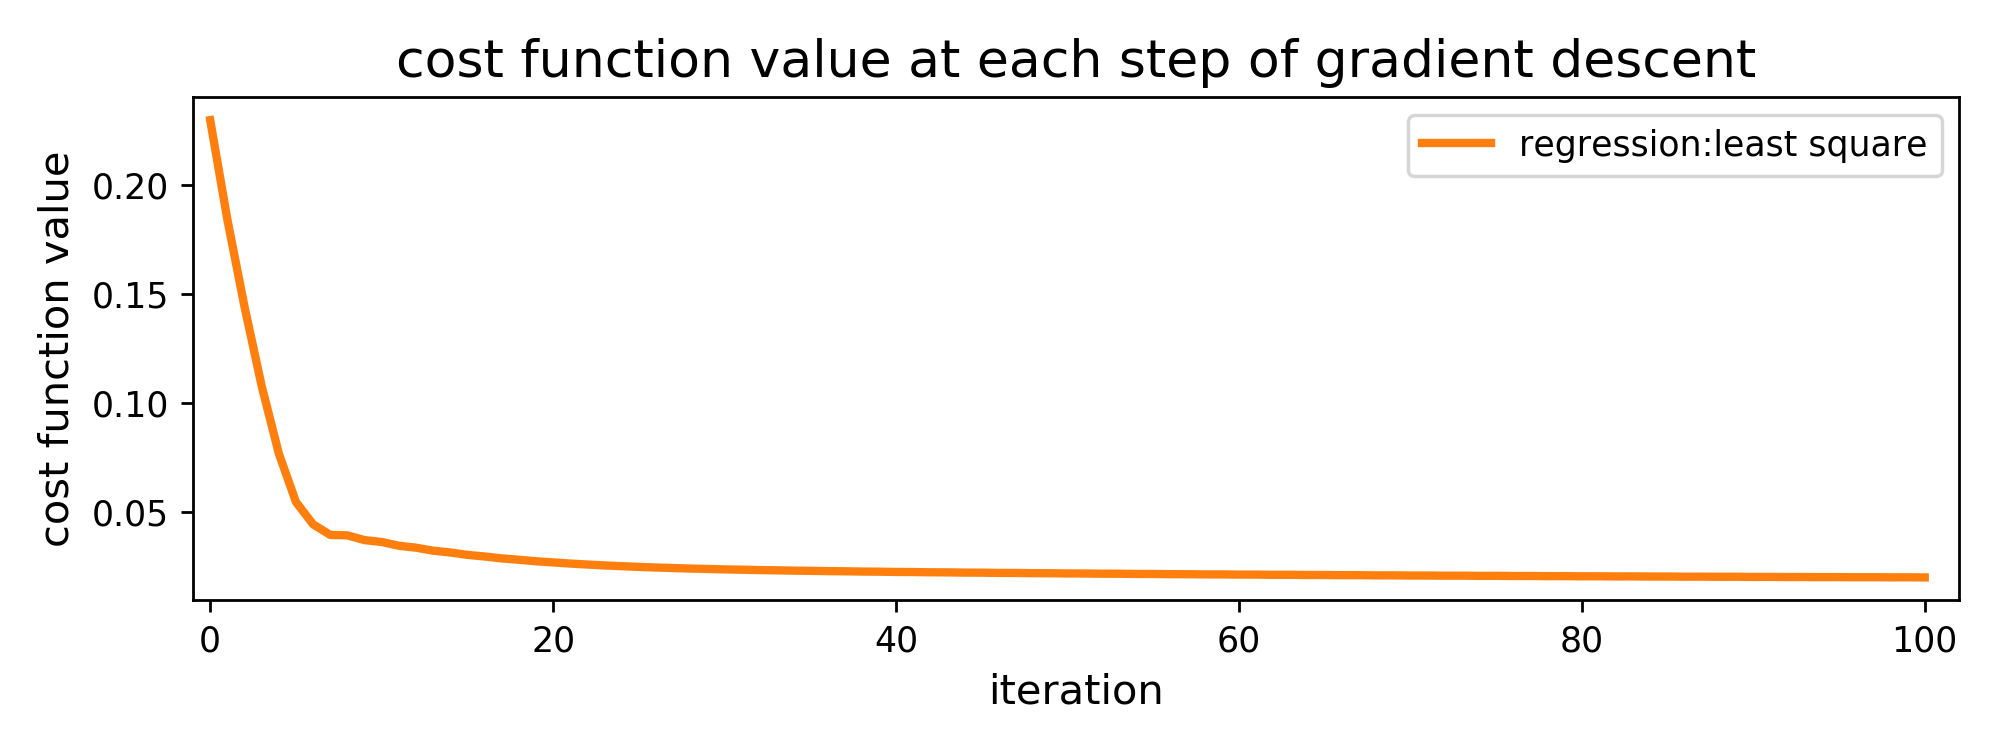

In [218]:
plotter_demo = custom_plotter.Visualizer()

# plot cost function history
start = 0   # at which iteration to begin plotting the cost function history
cost_histories = [[],cost_history]

labels = ['','regression:least square']
plotter_demo.compare_regression_histories(cost_histories,start = start,labels = labels)

## 4.Showing regression

<IPython.core.display.Javascript object>


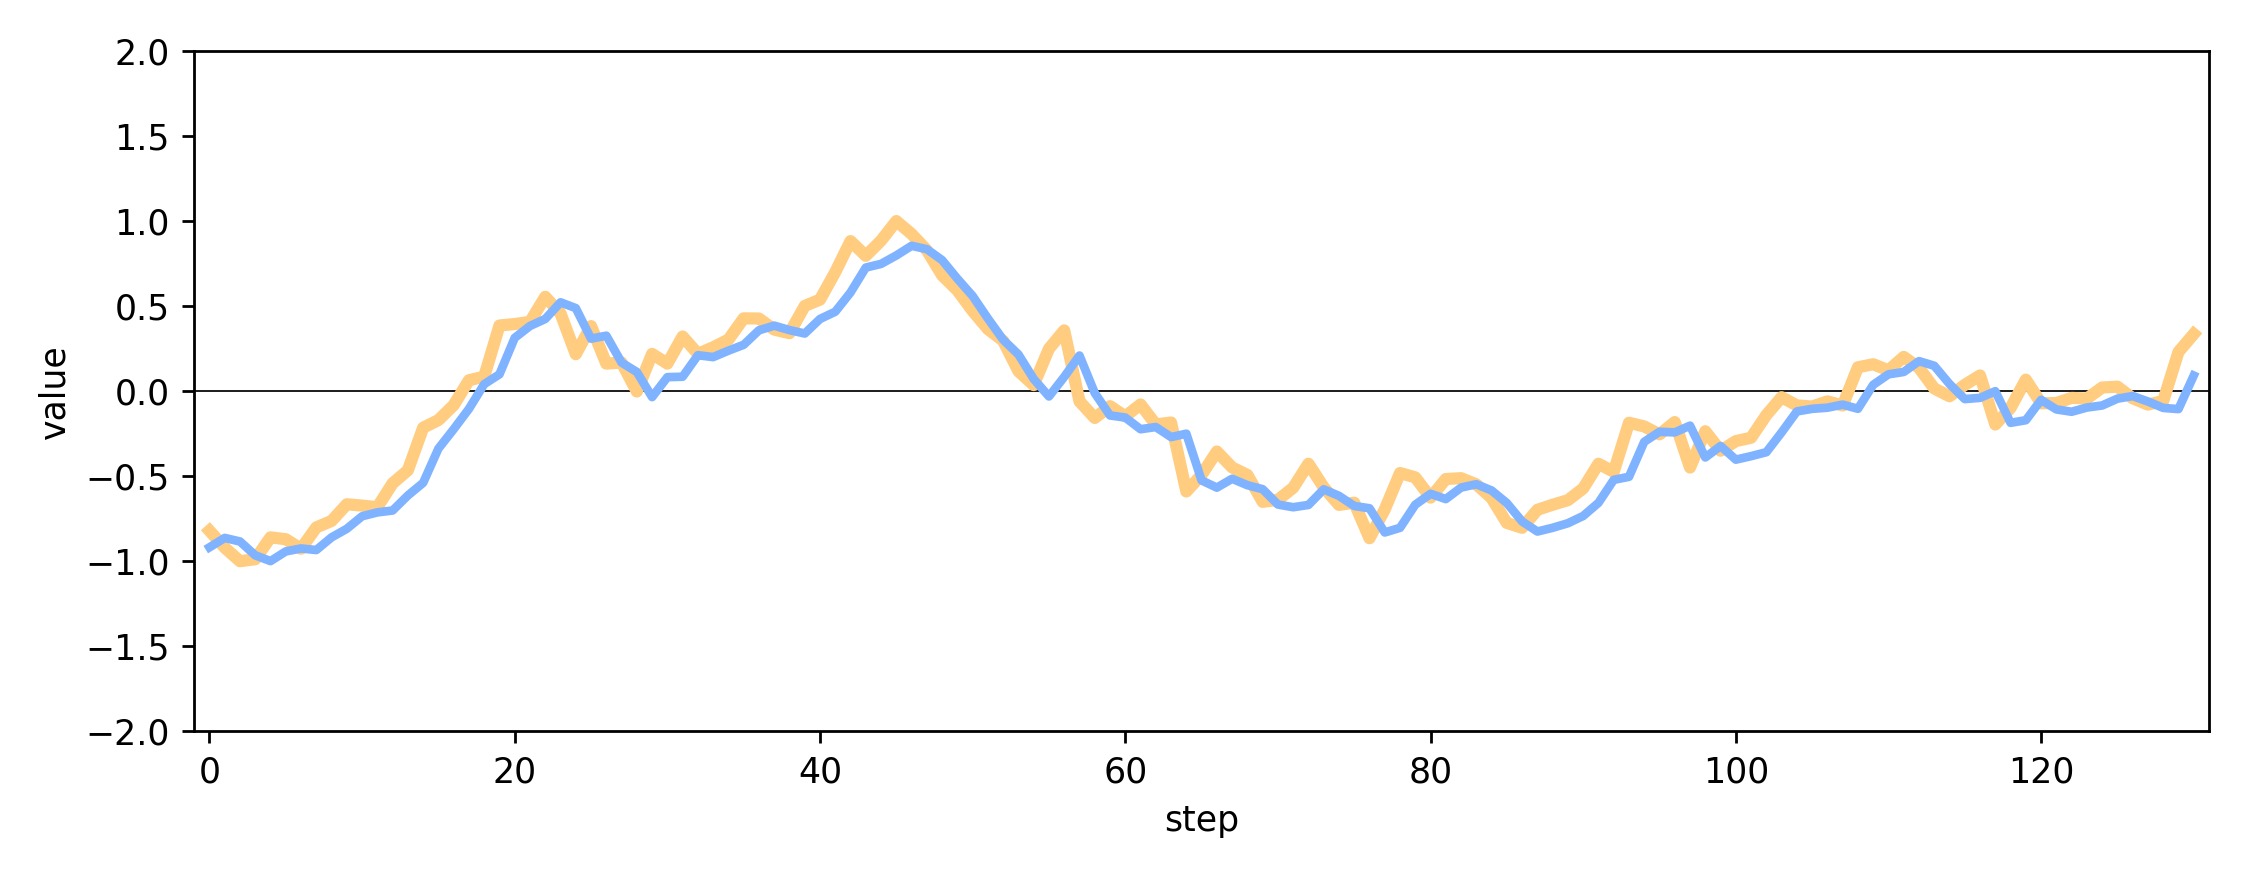

In [219]:
predict_outputs,states = test.static_rnn(weight_history[-1])
plot_regression_sequence = sequence_plotter.Visualizer()          
plot_regression_sequence.show_sequences(seq1 = Y,seq2 = predict_outputs)

# Implementing RNN on text generator

In [192]:
import text_parsing_utils as util

## 1.Load text data

In [226]:
# load in and preprocess text
csvname = "war_of_the_worlds.txt"
text = util.load_preprocess(csvname)

# parse into individual characters
chars,keys,chars_to_keys,keys_to_chars = util.parse_chars(text)

### Generating input/output pairs

In [268]:
num_chars = len(chars)
#get the different chars' number, which are the class number of labels
unique_chars = len(np.unique(chars))

order = 100
#parse the chars(sequence) to the datasets
x = []
y = []

# I take the first 3000 datapoints
for i in range(order,10000):
    # grab current key, and previous order keys
    next_key = keys[i]
    prev_keys = np.array(keys[i-order:i])
    
    # collect
    x.append(prev_keys)
    y.append(next_key)
x = np.array(x)
print('input data structure:')
print(np.shape(x))
print('-------------------------------')
y = np.array(y)
print('label structure:')
print(np.shape(y))
print('-------------------------------')

input data structure:
(9900, 100)
-------------------------------
label structure:
(9900,)


**Here, the first 10,000 input/output pairs from our training database to learn on, which means we are learning on a small subset of the larger version. Since the limitation of our own computer computation and memory** 

**Also, the 10,000 input/output pairs mean the whole time sequence data(text) lenth is 10,000-(window_size). window_size is the order, which will change the shape for each time step input. I don't use the one-hot coding for input, that will keep each time step input is a vector=(window_size,1), not a matrix. And keep this will easily to use our cost function.**

**To DO: I think here we should consider about when each time step input is a matrix=(window_size,input_dimension), and the form of our softmax. Maybe in that case the cost should be cross-entropy, cause each step output is (input_dimension,1) instead of a scalar which just representing the class it belongs.** 

In [278]:
print('There are '+ str(len(np.unique(y)))+' classes, each of them representing a character or a symbol')

There are 38 classes, each of them representing a character or a symbol


### Normalize the input, cause I don't use the one-hot coding for the input and output.

In [271]:
normalizer,inverse_normalizer = normalizers.standard(x.T)
x = normalizer(x.T).T

## 2. Set up RNN

In [272]:
text_generator = RNN(cell='simple_RNN',input_sequence=x,output_sequence=y,hidden_dim=38,name='classification')
w_init = text_generator.initial_weights()

(9900, 100)


## 3.Training

In [273]:
startTime= datetime.now()

g = text_generator.multiclass_softmax
w = w_init
alpha_choice = 10**(-1)
max_its = 100
version = 'normalized'
weight_history =  optimizer.gradient_descent(g,w,alpha_choice,max_its,version,verbose = True)

timeElapsed=datetime.now()-startTime 

print('Time elpased (hh:mm:ss.ms) {}'.format(timeElapsed))

started step 0 of 100
started step 5 of 100
started step 10 of 100
started step 15 of 100
started step 20 of 100
started step 25 of 100
started step 30 of 100
started step 35 of 100
started step 40 of 100
started step 45 of 100
started step 50 of 100
started step 55 of 100
started step 60 of 100
started step 65 of 100
started step 70 of 100
started step 75 of 100
started step 80 of 100
started step 85 of 100
started step 90 of 100
started step 95 of 100
finished all 100 steps
Time elpased (hh:mm:ss.ms) 0:14:43.396485


In [274]:
cost_history=[g(w) for w in weight_history]
count_history=[text_generator.multiclass_counting_cost(w) for w in weight_history] 

<IPython.core.display.Javascript object>


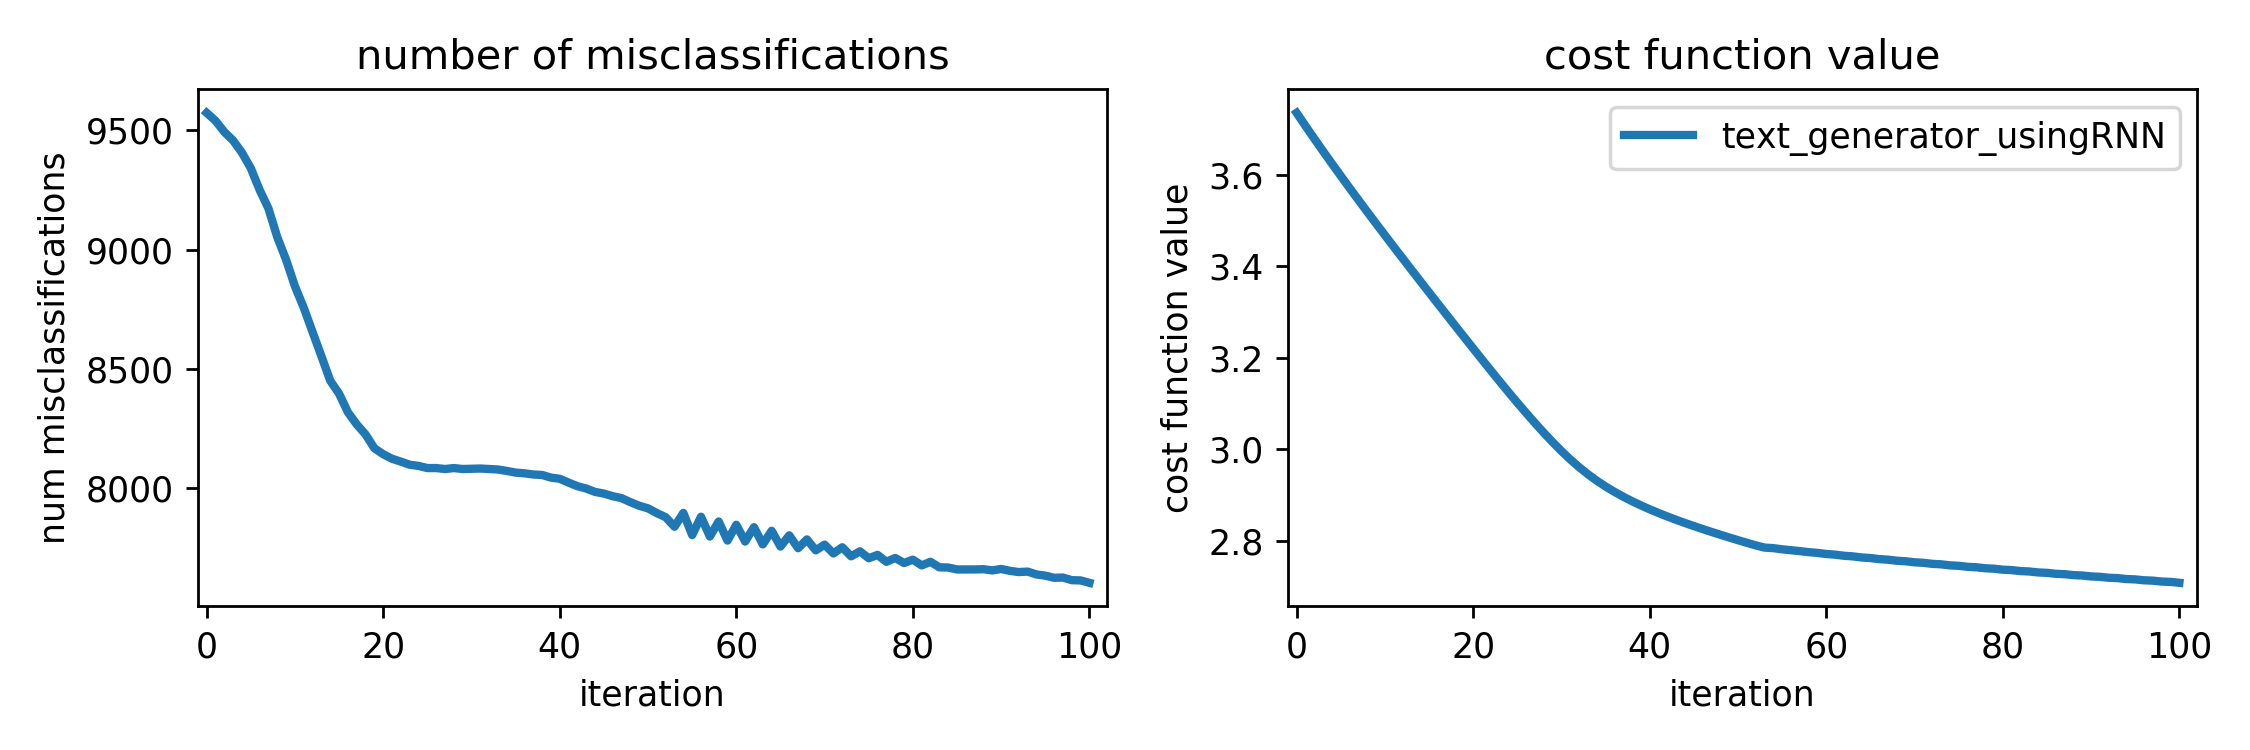

In [275]:
plotter = custom_plotter.Visualizer()

# plot cost and count function history
plotter.compare_classification_histories([count_history],[cost_history],start = 0,labels = ['text_generator_usingRNN',''])

## TO DO: The line still going down, since the limitation of my own computer. Maybe we can try this on AWS, and make our hidden_units bigger, and more training iterations. The result maybe improve!